In [1]:
%pip install albumentations opencv-python matplotlib numpy pandas tqdm pillow rich scikit-image scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import lzma
import os
import pickle
import re
import shutil
import tarfile
from collections import Counter
from typing import Any, Callable
import glob

import albumentations as A
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
import seaborn as sns

from PIL import Image
from rich import print
from skimage import feature, transform
# from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# **Data Exploration**

In [3]:
# Replace your input and output file to a appropriate folder and place
file_path = '/kaggle/input/lfw-dataset/lfw-funneled.tgz'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/kaggle/working/Raw/lfw-funneled')

Original_folder is the file path to our dataset

In [4]:
original_folder ="/kaggle/working/Raw/lfw-funneled/lfw_funneled"
# Initialize counters
jpg_count = 0
other_count = 0

# Create a dictionary to store file types and their counts
file_types = {}

# Iterate through files in the directory
for file in os.listdir(original_folder):
    file_path = os.path.join(original_folder, file)
    if os.path.isfile(file_path):
        # Get the file extension
        file_extension = os.path.splitext(file)[1].lower()

        # Update the file type counts
        if file_extension == '.jpg':
            jpg_count += 1
        else:
            other_count += 1
            if file_extension in file_types:
                file_types[file_extension] += 1
            else:
                file_types[file_extension] = 1

# Print the counts
for file_type, count in file_types.items():
    print(f"{file_type}: {count}")
print(f"There are {other_count} text Files.")

.txt: 11

There are 11 text Files.

#### Exploring number of image files across all people and find total number of image files

In [5]:
count_1 = 0
count_2 = 0
count_10 = 0
jpg_count = 0

# Iterate through each folder in the directory
for folder in os.listdir(original_folder):
    folder_path = os.path.join(original_folder, folder)
    if os.path.isdir(folder_path):
        # Initialize image count for the current folder
        image_count = 0

        # Iterate through files in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                # Check file extension
                if file.lower().endswith('.jpg'):
                    # Increment image count
                    image_count += 1
                    jpg_count += 1

        # Check image count and update counters
        if image_count == 1:
            count_1 += 1
        elif 1 < image_count < 20:
            count_2 += 1
        elif image_count >= 20:
            count_10 += 1

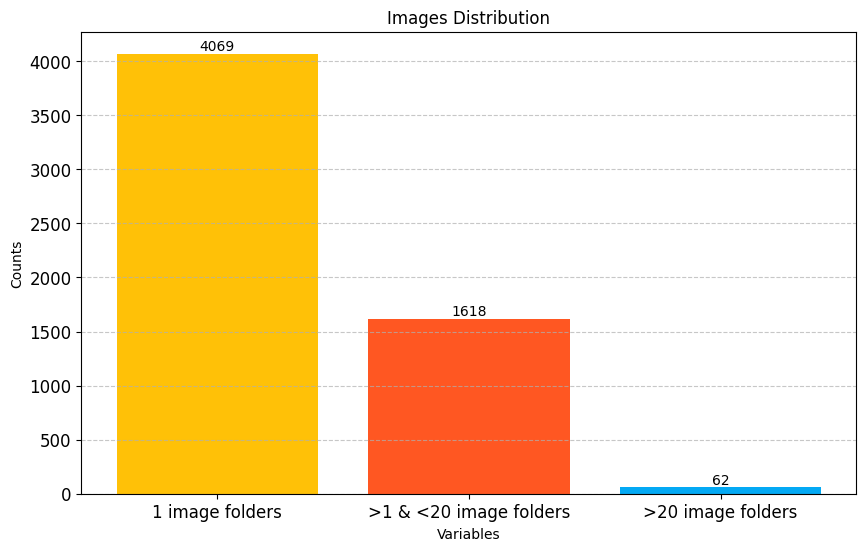

Folders (Idenity) with 1 image: 4069

Folders (Idenity) with more than 1 & less than 20 images: 1618

Folders (Idenity) with more than 20 images: 62

Total JPG files: 13233

In [6]:
variables = ['1 image folders', '>1 & <20 image folders', '>20 image folders']
counts = [count_1, count_2, count_10]

colors = ['#FFC107', '#FF5722', '#03A9F4']

plt.figure(figsize=(10, 6))
plt.bar(variables, counts, color=colors)

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Variables')
plt.ylabel('Counts')
plt.title('Images Distribution')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
# Print the counts
print(f"Folders (Idenity) with 1 image: {count_1}")
print(f"Folders (Idenity) with more than 1 & less than 20 images: {count_2}")
print(f"Folders (Idenity) with more than 20 images: {count_10}")
print(f"Total JPG files: {jpg_count}")

#### Creating a dataframe which contains the 'person' columns and 'path' file directory

In [7]:
df = []
i = 1
for path in glob.iglob(os.path.join(original_folder, "**", "*.jpg")):
    person = os.path.basename(os.path.dirname(path))
    df.append({"person": person, "path": path})


if df:
    df = pd.DataFrame(df)
    df = df.groupby("person").filter(lambda x: len(x) < 550)
    print(df.head(10))
else:
    print("No matching files found.")

person                                               path
0  Cyndi_Thompson  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
1  Cyndi_Thompson  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
2   Mitar_Rasevic  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
3   Pinar_del_Rio  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
4     Paul_Vathis  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
5     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
6     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
7     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
8     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
9     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...

In [8]:
df.shape

(13233, 2)

#### Find top 5 people with most image files

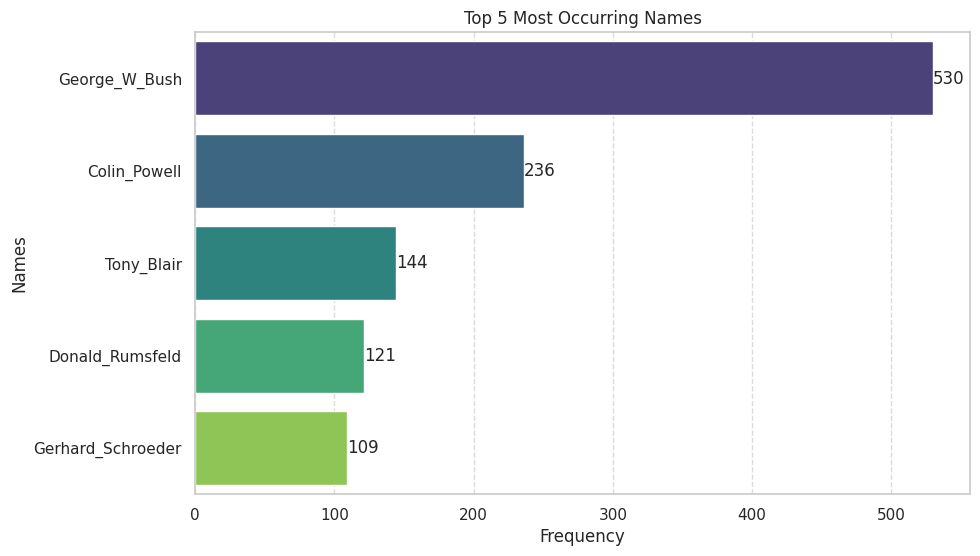

In [9]:
name_counts = df['person'].value_counts().sort_values(ascending=False)

top_names = name_counts.head(5)

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=top_names.values, y=top_names.index, hue=top_names.index, palette="viridis", ax=ax, dodge=False)

ax.legend().remove()
ax.set_xlabel('Frequency')
ax.set_ylabel('Names')
ax.set_title('Top 5 Most Occurring Names')
for i, name in enumerate(top_names.index):
    ax.text(top_names.values[i], i, str(top_names.values[i]), ha='left', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13233 entries, 0 to 13232
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   person  13233 non-null  object
 1   path    13233 non-null  object
dtypes: object(2)
memory usage: 310.1+ KB


In [11]:
df.describe()

person                                               path
count           13233                                              13233
unique           5749                                              13233
top     George_W_Bush  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...
freq              530                                                  1

From using describe(), we can see that total number of image files is 13233 , but there are only 5749 unique person, so some people have more image files than others, and proven right when we find top 5 people with most images before

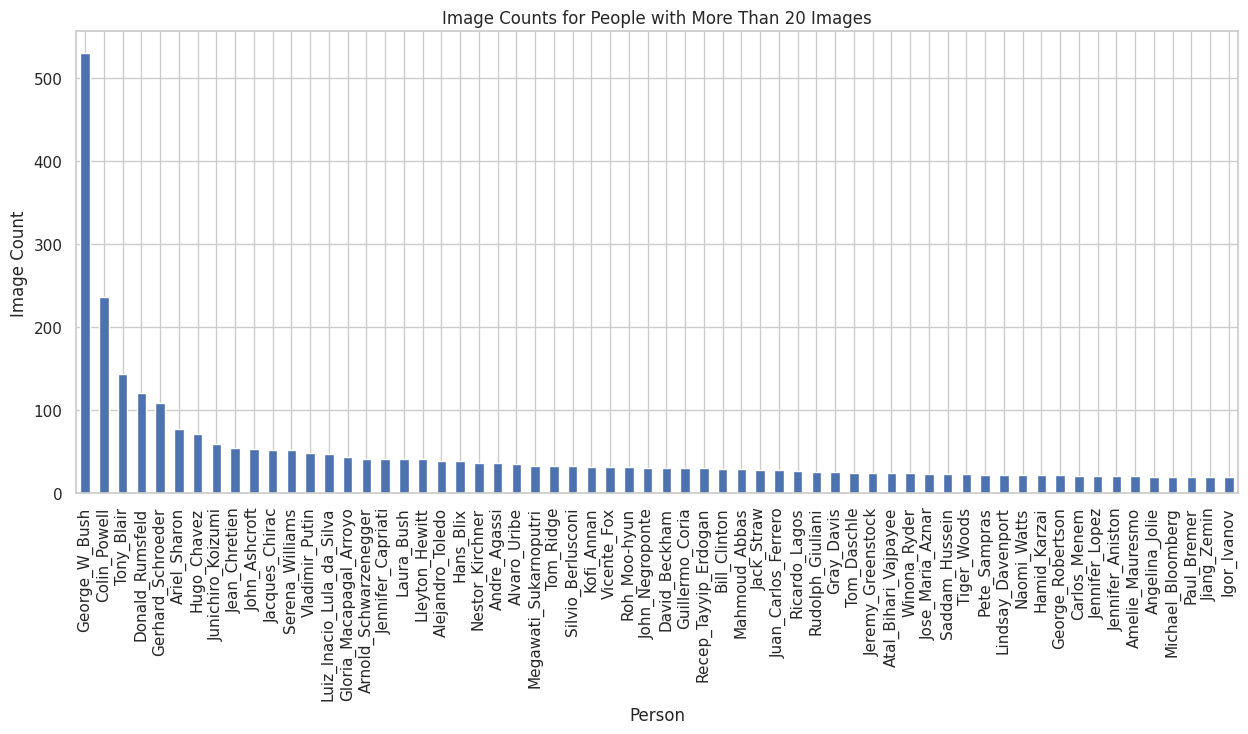

In [12]:
# Count the number of images for each person
image_count = df['person'].value_counts()

# Filter the counts for people with more than 20 images
image_count_filtered = image_count[image_count >= 20]
plt.rcParams['font.size'] = 10

plt.figure(figsize=(15, 6))
image_count_filtered.plot(kind='bar')
plt.xlabel('Person')
plt.ylabel('Image Count')
plt.title('Image Counts for People with More Than 20 Images')
plt.xticks(rotation=90)
plt.show()

#### Find the size of each image files and append it as a colume

In [13]:
image_sizes = []
for file in df['path']:
    image = cv2.imread(file)
    if image is not None:  # Check if the image was successfully loaded
        size = image.shape[:2]  # Get the dimensions (height, width)
        image_sizes.append(size)

# Update the dataset DataFrame with the 'Size' column
df['size'] = image_sizes

df.head(10)

person                                               path  \
0  Cyndi_Thompson  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
1  Cyndi_Thompson  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
2   Mitar_Rasevic  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
3   Pinar_del_Rio  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
4     Paul_Vathis  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
5     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
6     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
7     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
8     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   
9     Mick_Jagger  /kaggle/working/Raw/lfw-funneled/lfw_funneled/...   

         size  
0  (250, 250)  
1  (250, 250)  
2  (250, 250)  
3  (250, 250)  
4  (250, 250)  
5  (250, 250)  
6  (250, 250)  
7  (250, 250)  
8  (250, 250)  
9  (250, 250)

#### Visualize the distribution of image size

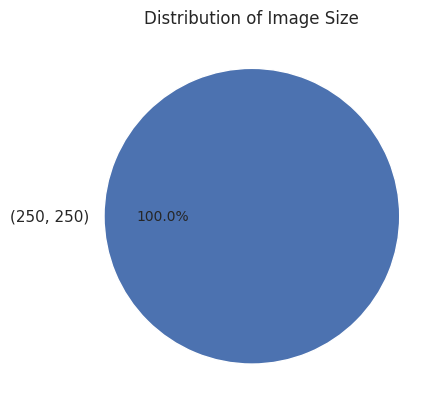

size
(250, 250)    13233
Name: count, dtype: int64

In [14]:
image_areas = df['size'] 
unique_areas, counts = np.unique(image_areas, return_counts=True)
plt.pie(counts, labels=unique_areas, autopct="%1.1f%%")
plt.title('Distribution of Image Size')
plt.show()

size_count = df['size'].value_counts()
print(size_count)

#### Display first 10 images

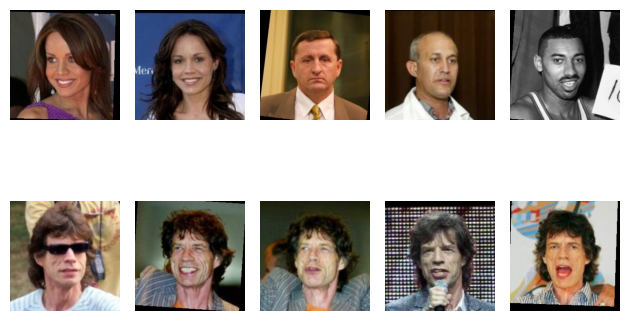

In [15]:
for i, image_path in enumerate(df['path'][0:10]):
    pic = plt.imread(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(pic)
    plt.axis('off')
plt.tight_layout()

plt.show()
  

From the results, we can see that although all the images are the same size, not all images are properly aligned, some are tilted in different angles

> # Base on requirement from lecturer, We have chose to take only person who have equal and more than 20 images to study for facial recognition project. Therefore base on the bar graph above, there are 62 identity that we need to study. 

# **Data preprocessing**

In [16]:
def identity(x):
    return x

This function helps us visualize images in a grid. It's a great tool for getting a quick look at what our images actually look like.

In [17]:
def visualize_image(axes_array, images_array, labels_array, figure):
    axes_array = axes_array.flatten()

    # assert len(axes_array) == len(images_array) == len(labels_array)
    assert len(axes_array) <= len(images_array)
    assert len(axes_array) <= len(labels_array)

    for i, ax in enumerate(axes_array):
        img = ax.imshow(images_array[i], cmap="gray")
        figure.colorbar(img, ax=ax)
        ax.set_title(labels_array[i])
        ax.axis("off")


This class **LazyData** is like a smart data loader. Instead of loading all the data at once (which can be memory-intensive), it waits until the very moment the data is needed before loading it. This is particularly useful when dealing with large datasets. It’s also versatile and can handle different types of data thanks to its ‘**load_strategy**’ parameter.

Also This function (dataset) is like a custom dataset loader. It goes into a specified directory, looks at all the subdirectories and files, and based on the criteria we set (like **minimum** and **maximum** number of faces), it creates a dataset. It’s like a librarian who knows exactly which books (data) to fetch based on our requirements.

And this function(**fetch_lfw_people**) is a specialized version of the dataset function. It’s pre-configured to fetch the LFW (Labeled Faces in the Wild) dataset. It’s like having a librarian who is an expert in fetching books on a specific topic.


In [18]:
class LazyData:
    def __init__(
        self,
        filename: str,
        load_strategy: str | Callable[[str | bytes], Any] | None = None,
    ):
        self._filename = filename
        self._data = None
        self._load_strategy = load_strategy

    def __call__(self):
        if self._data is None:
            self._build_data()
        return self._data

    def __load_strategy_image(buf) -> np.ndarray[np.uint8]:
        img = mpimg.imread(buf, format="jpg")
        return img

    def _build_data(self):
        with open(self._filename, "rb") as f:
            if self._load_strategy is None:
                self._data = f.read()
            elif self._load_strategy == "image":
                self._data = LazyData.__load_strategy_image(self._filename)
            else:
                buf = f.read()
                self._data = self._load_strategy(buf)


def dataset(
    path: str,
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle: bool = False,
    random_state: int | None = None,
    verbose: bool | None = True,
):
    if random_state is not None:
        np.random.seed(random_state)

    excluded_dirs = []
    capped_dirs = []
    capped_counts = {}
    for direc in os.listdir(path):
        if os.path.isdir(os.path.join(path, direc)):
            if min_faces is not None:
                if len(os.listdir(os.path.join(path, direc))) < min_faces:
                    excluded_dirs.append(direc)
            if max_faces is not None:
                if len(os.listdir(os.path.join(path, direc))) > max_faces:
                    if hard_limit:
                        excluded_dirs.append(direc)
                    else:
                        capped_dirs.append(direc)

    ds = []
    tracker = tqdm.tqdm if verbose else identity
    pattern = re.compile(r"(.*)_(?:\d{4}).jpg")

    for root, dirs, files in tracker(os.walk(path)):
        for file in files:
            if file.endswith(".jpg"):
                match = pattern.match(file)
                if match:
                    target = match.group(1)

                if target in excluded_dirs:
                    continue

                if max_faces is not None:
                    if target in capped_dirs:
                        if target not in capped_counts:
                            capped_counts[target] = 0
                        capped_counts[target] += 1
                        if capped_counts[target] > max_faces:
                            continue

                ds.append(
                    [
                        LazyData(
                            os.path.abspath(os.path.join(root, file)),
                            load_strategy="image",
                        ),
                        target,
                    ]
                )

    if shuffle:
        np.random.shuffle(ds)

    return np.array(ds)


def fetch_lfw_people(
    path_to_dataset: str = "Dataset/Raw",
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle: bool = True,
    random_state: int | None = None,
    verbose: bool = True,
):
    dst = dataset(
        path_to_dataset,
        min_faces=min_faces,
        max_faces=max_faces,
        hard_limit=hard_limit,
        shuffle=shuffle,
        random_state=random_state,
        verbose=verbose,
    )
    X = dst[:, 0]
    Y = dst[:, 1]
    return X, Y


In here we provide a visual inspection of the LFW (Labeled Faces in the Wild) dataset. By displaying the first five images and their corresponding labels, it allows for an initial examination of the data’s characteristics. By doing so we can see the size and examine the images.

Displaying of the first 5 images corresponding to their labels.

5750it [00:01, 5710.06it/s] 


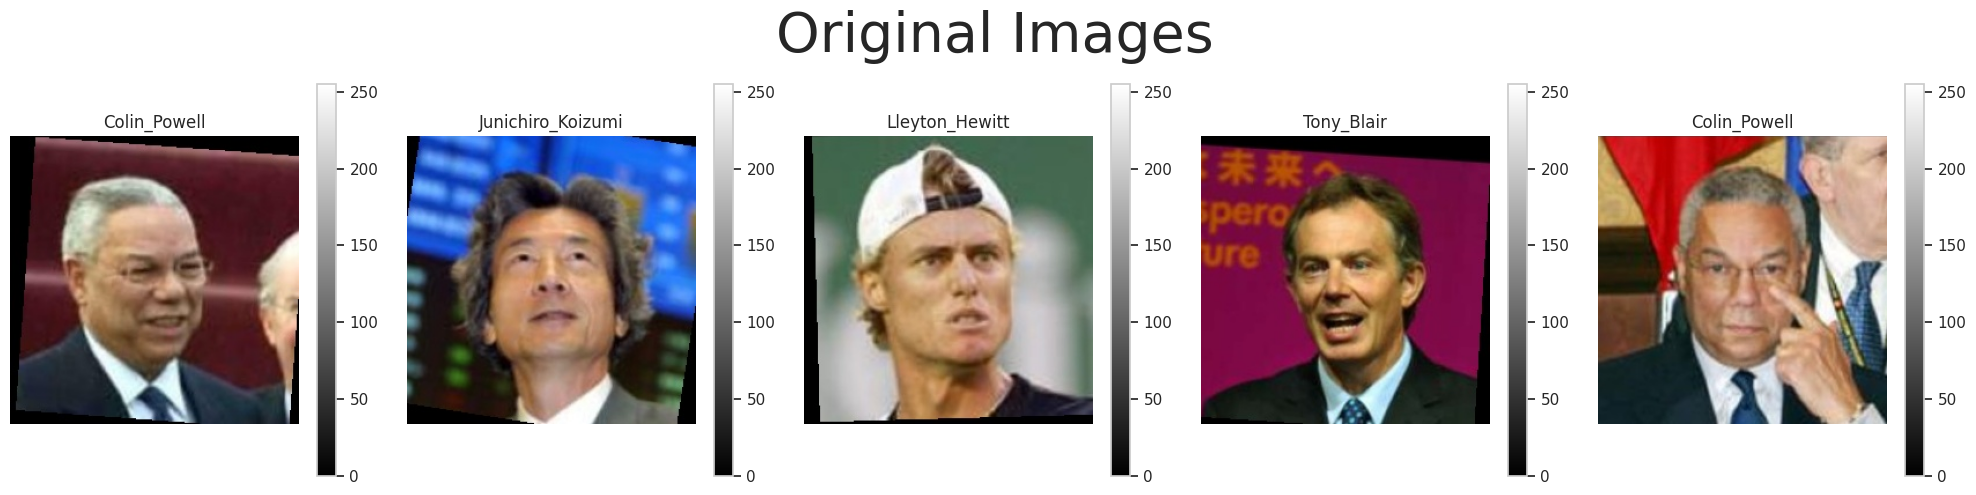

In [19]:
X, Y = fetch_lfw_people(path_to_dataset="/kaggle/working/Raw/lfw-funneled/lfw_funneled")
__x = []
for x in range(5):
    __x.append(X[x]())

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()
visualize_image(axes, __x, Y, fig)
plt.suptitle("Original Images", size=40)
plt.tight_layout()
plt.show()

### Augmentation
Images are augmented using the Albumentations library. The default augmentation parameters are defined in the default_transform variable. Augmentation is performed to enhance the diversity of the dataset and improve the model's generalization ability:

By doing data augmentation. It increases the amount of training data, improves the model’s robustness to variations in face images, prevents overfitting, and helps the model handle real-world variations in faces. This leads to a more accurate and reliable face recognition system.

In [20]:
default_transform = A.Compose(
    [
        A.RandomCrop(width=200, height=200),
        A.HorizontalFlip(p=0.5),
        # A.RandomScale(scale_limit=(-0.5, 2.0), p=0.5),
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.2, rotate_limit=15),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ]
)


def augment_data(
    img: np.ndarray,
    augmentation_count: int = 10,
    augmentation_pipeline=None,
    desired_shape: tuple[int, int] = (250, 250),
) -> list[np.ndarray]:
    images = []
    if augmentation_pipeline is None:
        augmentation_pipeline = default_transform
    for _ in range(augmentation_count):
        aug_image = augmentation_pipeline(image=img)["image"]
        aug_image = Image.fromarray(aug_image).resize(desired_shape)
        aug_image = np.array(aug_image)
        images.append(aug_image)
    return images

To make sure that everything is following what expected we need to make sure that the function is augmented the training data by visualizing the augmented images

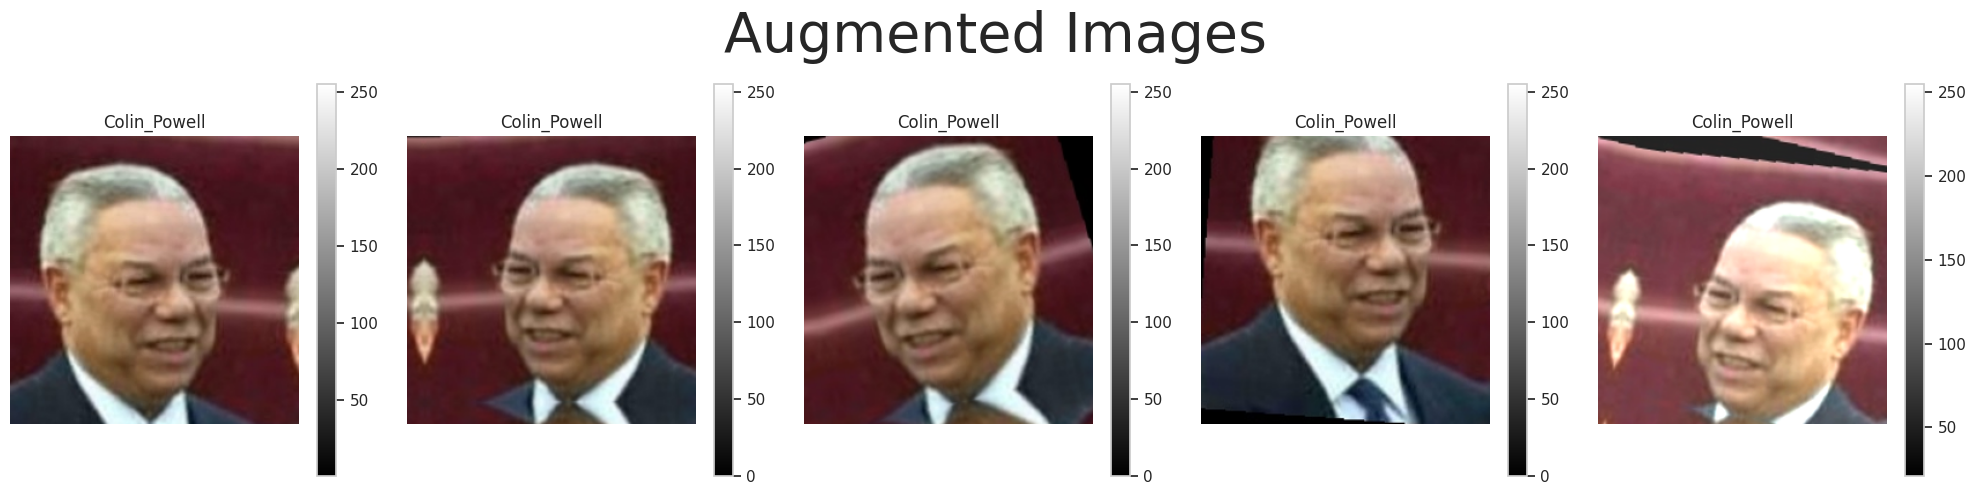

In [21]:
aug_data = augment_data(
    __x[0],
    augmentation_count = 5,
)

aug_Y = [Y[0]] * 5

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()
visualize_image(axes, aug_data, aug_Y, fig)
fig.suptitle("Augmented Images", size=40)
plt.tight_layout()
plt.show()

Since we don't want the augmented data to be in the test set, we make The dump_test_files function, is designed to organize and store test images for a face recognition system. It categorizes the images based on their labels, stores them in a structured directory format, and finally compresses the directory into a zip file. This organization and compression facilitate efficient storage and easy retrieval of the test images. It also ensures that the test data is kept separate and intact, which is crucial for unbiased evaluation of the face recognition model.

The export_dataset_objects function is integral to the data preprocessing pipeline of our face recognition system. It ensures efficient and consistent model training by storing the preprocessed data (x_train, y_train, x_test, y_test). This not only saves computational resources by avoiding repeated preprocessing, but also guarantees reproducibility of our experiments. Furthermore, the stored preprocessed data can be flexibly used for various tasks, enhancing the versatility of our project. 

In [22]:
def dump_test_files(x_test, y_test, path_prefix: str, verbose=True):
    # clear out the directory
    if os.path.exists(path_prefix):
        shutil.rmtree(path_prefix)

    if os.path.exists(path_prefix + ".zip"):
        os.remove(path_prefix + ".zip")

    os.makedirs(path_prefix)

    freq_table = {}
    for i, x in enumerate(x_test):
        target = y_test[i]
        if target not in freq_table:
            freq_table[target] = 0
            os.makedirs(os.path.join(path_prefix, str(target)))
        freq_table[target] += 1

        # write image as jpeg
        Image.fromarray(x).save(
            os.path.join(
                path_prefix, str(target), f"{target}_{freq_table[target]:04}.jpg"
            )
        )

    shutil.make_archive(path_prefix, "zip", path_prefix)
    if verbose:
        print("[bold green]Test files dumped successfully[/bold green]")


def export_dataset_objects(
    path_to_dataset: str = "Dataset/Raw",
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle=True,
    random_state=None,
    test_size=0.2,
    verbose=True,
    augment=True,
    desired_shape: tuple[int, int] = (250, 250),
    augmentation_count: int = 10,
    augmentation_upto: int | None = None,
    augmentation_pipeline=None,
    experimental_export: bool = True,
):
    X, Y = fetch_lfw_people(
        path_to_dataset=path_to_dataset,
        min_faces=min_faces,
        max_faces=max_faces,
        hard_limit=hard_limit,
        shuffle=shuffle,
        random_state=random_state,
        verbose=verbose,
    )

    log = print if verbose else identity

    log("[bold green]Dataset loaded successfully[/bold green]")

    export_path = os.path.dirname(path_to_dataset)

    tracker = tqdm.tqdm if verbose else identity


    __x = []
    for x in tracker(X):
        __x.append(x())
    # # exit(1)

    __x = np.array(__x, copy=False)
    log("[bold green]Binary data loaded successfully[/bold green]")


    x_train, x_test, y_train, y_test = train_test_split(
        __x,
        Y,
        test_size=test_size,
        random_state=random_state,
        stratify=Y,
    )

    log("[bold green]Dataset split successfully[/bold green]")

    if augment:
        if augmentation_upto is None:
            xy = []
            for i, x in tracker(enumerate(x_train)):
                aug_data = augment_data(
                    x,
                    desired_shape=desired_shape,
                    augmentation_count=augmentation_count,
                    augmentation_pipeline=augmentation_pipeline,
                )

                for data in aug_data:
                    data = Image.fromarray(data).convert("L")
                    data = np.array(data, copy=False)
                    xy.append([data, y_train[i]])
                    
            log("[bold green]Augmentation done successfully[/bold green]")
            xy_data = np.array(xy, dtype=object, copy=False)
            log("[bold green]Augmented data converted to numpy array[/bold green]")
            if shuffle:
                np.random.shuffle(xy_data)
                log("[bold green]Augmented data shuffled successfully[/bold green]")

            x_train_data = xy_data[:, 0]
            log("[bold green]x_train_data split successfully[/bold green]")
            y_train_data = xy_data[:, 1]
            log("[bold green]y_train_data split successfully[/bold green]")
#             x_train_data = x_train_data / 255
#             log("[bold green]x_train_data normalized successfully[/bold green]")
#             x_test = x_test / 255
#             log("[bold green]x_test normalized successfully[/bold green]")
            if not experimental_export:
                x_train_data.dump(os.path.join(export_path, "x_train.npy"))
                y_train_data.dump(os.path.join(export_path, "y_train.npy"))
                x_test.dump(os.path.join(export_path, "x_test.npy"))
                y_test.dump(os.path.join(export_path, "y_test.npy"))
            else:
                np.savez_compressed(
                    os.path.join(export_path, "data.npz"),
                    x_train=x_train_data,
                    y_train=y_train_data,
                    x_test=x_test,
                    y_test=y_test,
                )
                log("[bold green]Dataset exported successfully[/bold green]")

        else:
            xy = []
            idents = {}
            for i, y in enumerate(y_train):
                if y in idents:
                    idents[y].append(i)
                else:
                    idents[y] = [i]
            log("[bold green]Identified classes successfully[/bold green]")

            if augmentation_upto == 0:
                # augment upto max_faces
                if max_faces is None:
                    raise Exception("max_faces must be int if augmentation_upto is 0")

                for y in idents:
                    augmentation_len = max_faces - len(idents[y])
                    for _k in range(augmentation_len):
                        # choose random image
                        random_image = np.random.choice(idents[y])
                        # augment it
                        aug_data = augment_data(
                            x_train[random_image],
                            desired_shape=desired_shape,
                            augmentation_count=1,
                            augmentation_pipeline=augmentation_pipeline,
                        )
                        aug_image = aug_data[0]
                        aug_image = Image.fromarray(aug_image).convert("L")
                        aug_image = np.array(aug_image, copy=False)
                        # add it to the dataset
                        xy.append([aug_image, y])
                    log(
                        "[bold green]Augmented upto max_faces successfully[/bold green]"
                    )
            elif augmentation_upto > 0:
                # augment upto augmentation_upto
                for y in idents:
                    faces = len(idents[y])
                    if augmentation_upto > faces:
                        augmentation_len = augmentation_upto - len(idents[y])
                        for _k in range(augmentation_len):
                            # choose random image
                            random_image = np.random.choice(idents[y])
                            # augment it
                            aug_data = augment_data(
                                x_train[random_image],
                                desired_shape=desired_shape,
                                augmentation_count=1,
                                augmentation_pipeline=augmentation_pipeline,
                            )
                            aug_image = aug_data[0]
                            aug_image = Image.fromarray(aug_image).convert("L")
                            aug_image = np.array(aug_image, copy=False)
                            # add it to the dataset
                            xy.append([aug_image, y])
                log(
                    "[bold green]Augmented upto augmentation_upto successfully[/bold green]"
                )
            else:
                raise Exception("augmentation_upto must be bool or int")

            # add the original image with the label
            for i, x in tracker(enumerate(x_train)):
                cv_image = Image.fromarray(x).convert("L")
                cv_image = np.array(cv_image, copy=False)
                xy.append([cv_image, y_train[i]])
            log("[bold green]Original images added successfully[/bold green]")

            xy_data = np.array(xy, dtype=object, copy=False)
            log("[bold green]Augmented data converted to numpy array[/bold green]")
            if shuffle:
                np.random.shuffle(xy_data)
                log("[bold green]Augmented data shuffled successfully[/bold green]")
            x_train_data = xy_data[:, 0]
            log("[bold green]x_train_data split successfully[/bold green]")
            y_train_data = xy_data[:, 1]
            log("[bold green]y_train_data split successfully[/bold green]")
#             x_train_data = x_train_data / 255
#             log("[bold green]x_train_data normalized successfully[/bold green]")
#             x_test = x_test / 255
#             log("[bold green]x_test normalized successfully[/bold green]")

            if not experimental_export:
                x_train_data.dump(os.path.join(export_path, "x_train.npy"))
                y_train_data.dump(os.path.join(export_path, "y_train.npy"))
                x_test.dump(os.path.join(export_path, "x_test.npy"))
                y_test.dump(os.path.join(export_path, "y_test.npy"))
            else:
                np.savez_compressed(
                    os.path.join(export_path, "data.npz"),
                    x_train=x_train_data,
                    y_train=y_train_data,
                    x_test=x_test,
                    y_test=y_test,
                )

                log("[bold green]Dataset exported successfully[/bold green]")

    else:


        if not experimental_export:
            x_train.dump(os.path.join(export_path, "x_train.npy"))
            y_train.dump(os.path.join(export_path, "y_train.npy"))
            x_test.dump(os.path.join(export_path, "x_test.npy"))
            y_test.dump(os.path.join(export_path, "y_test.npy"))
        else:
            np.savez_compressed(
                os.path.join(export_path, "data.npz"),
                x_train=x_train,
                y_train=y_train,
                x_test=x_test,
                y_test=y_test,
            )



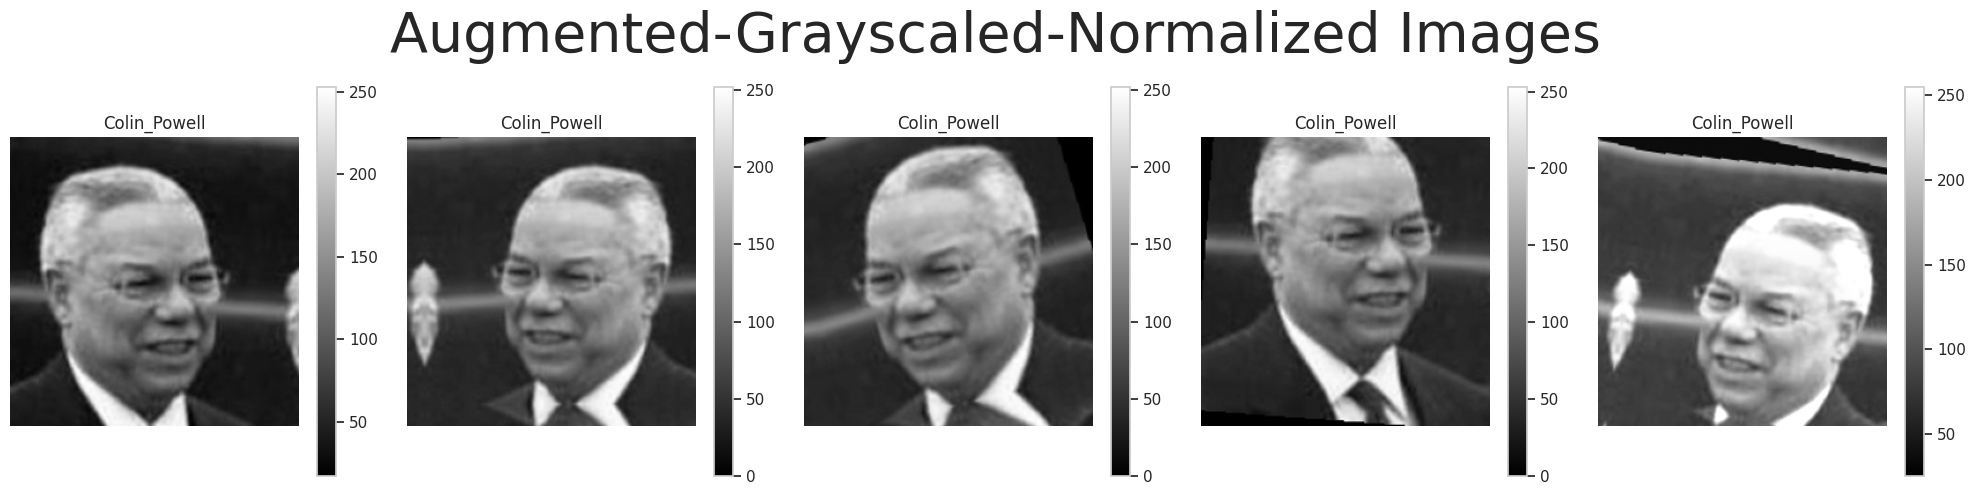

In [23]:
aug_data = np.array(aug_data)
gs_aug_data = []
for data in aug_data:
    img = Image.fromarray(data).convert("L")
    img = np.array(img)
    gs_aug_data.append(img)
gs_aug_data = np.array(gs_aug_data)
# gs_aug_data = gs_aug_data / 255

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()
visualize_image(axes, gs_aug_data, aug_Y, fig)
plt.suptitle("Augmented-Grayscaled-Normalized Images", size=40)
plt.tight_layout()
plt.show()

In [24]:
export_dataset_objects(
        path_to_dataset="/kaggle/working/Raw/lfw-funneled/lfw_funneled",
        shuffle=True,
        min_faces=20,
        max_faces=None,
        hard_limit=False,
        augment=True,
        augmentation_upto=150,
        experimental_export=True,
        test_size=0.3
    )

5750it [00:01, 5546.68it/s] 


Dataset loaded successfully

100%|██████████| 3023/3023 [00:03<00:00, 953.58it/s]


Binary data loaded successfully

Dataset split successfully

Identified classes successfully

Augmented upto augmentation_upto successfully

2116it [00:00, 3797.95it/s]


Original images added successfully

Augmented data converted to numpy array

Augmented data shuffled successfully

x_train_data split successfully

y_train_data split successfully

Dataset exported successfully

# **Data Feature extraction**

In this step we only want to make sure that our data is ready for feature extraion by doing visualizing, plotting images and printing inportant values.

In [25]:
data = np.load("/kaggle/working/Raw/lfw-funneled/data.npz", allow_pickle=True)

In [26]:
X = data['x_train']
Y = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

In [27]:
print(X.shape)
print(X[0].shape)

(9536,)

(250, 250)

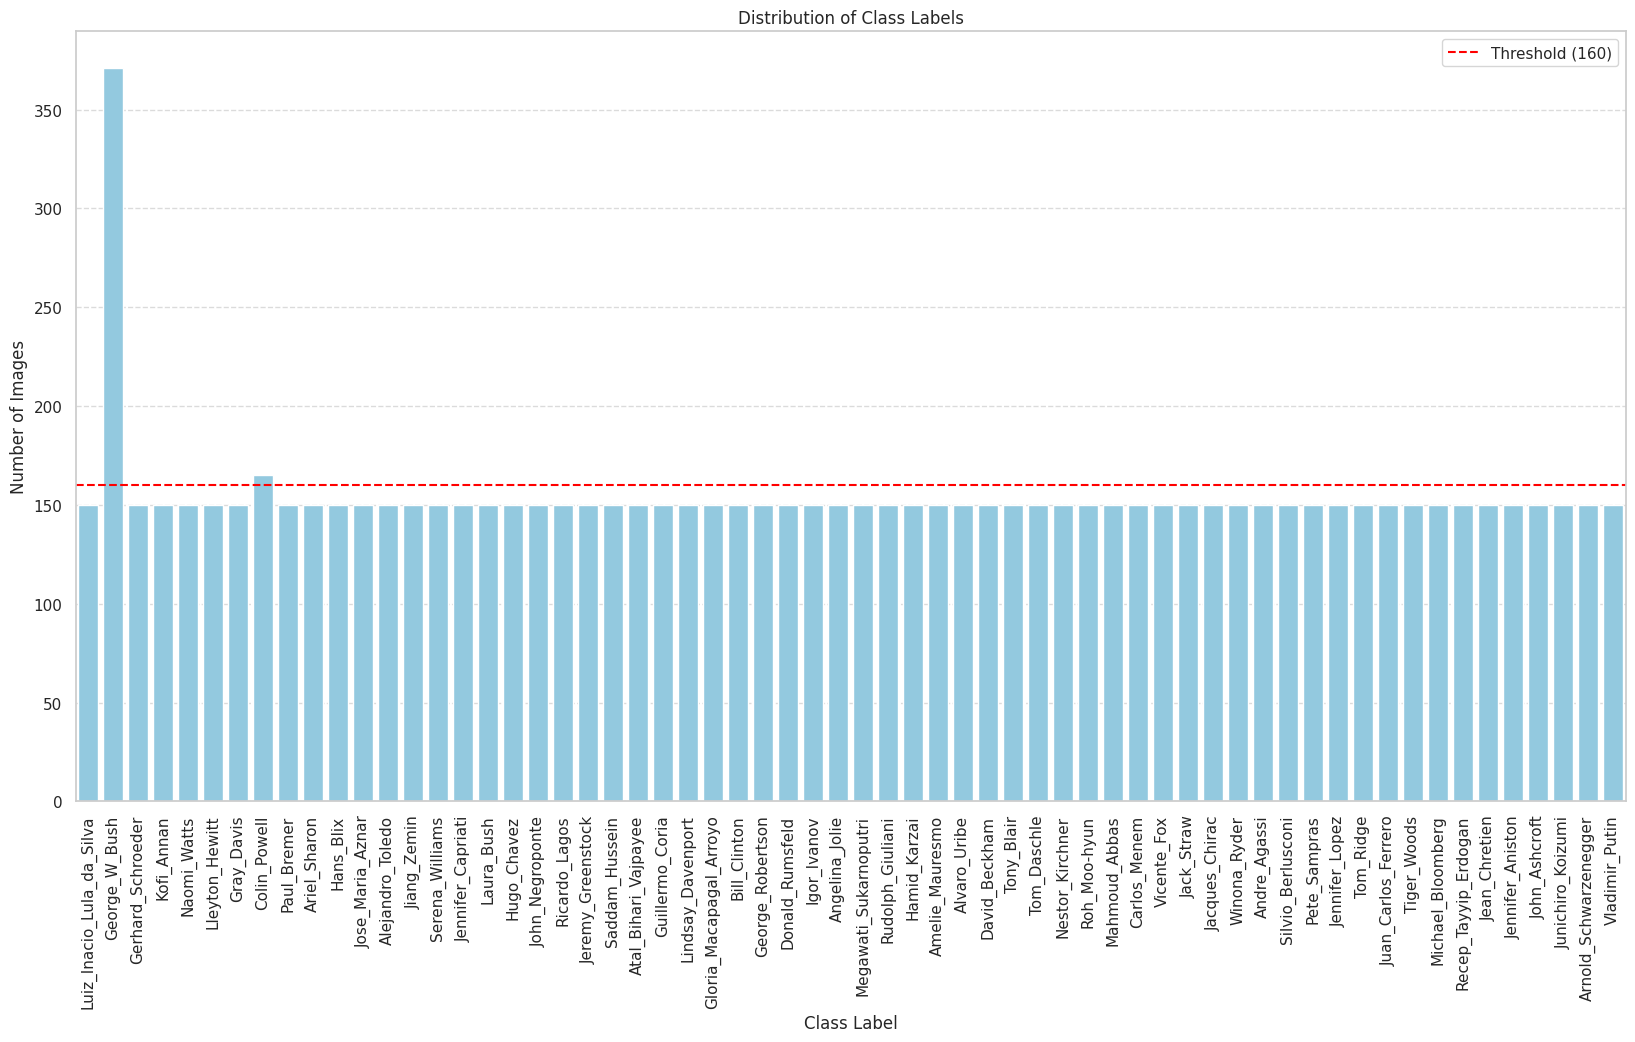

In [28]:
label_counts = Counter(Y)

data = {'Class Label': list(label_counts.keys()), 'Number of Images': list(label_counts.values())}
df = pd.DataFrame(data)

plt.figure(figsize=(20, 10))
sns.barplot(x='Class Label', y='Number of Images', data=df, color='skyblue')
plt.axhline(y=150, color='red', linestyle='--', label='Threshold (160)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Class Labels')
plt.legend()

plt.show()

In [29]:
# Assuming y_train is your list of labels corresponding to x_train
unique_identities = np.unique(Y)

print(f"There are {len(unique_identities)} unique identities.")

There are 62 unique identities.

In [30]:
# Assuming y_train is your list of labels corresponding to x_train
label_counts = Counter(Y)

# Find the identity with the least number of images
min_label, min_count = min(label_counts.items(), key=lambda x: x[1])

print(f"Identity {min_label} has the least number of images: {min_count} images")

Identity Luiz_Inacio_Lula_da_Silva has the least number of images: 150 images

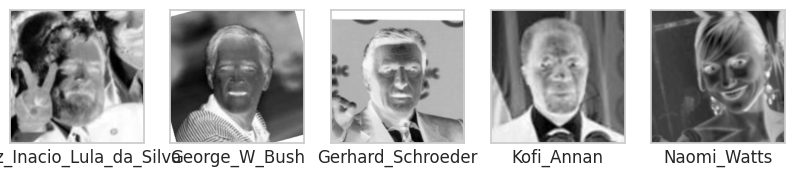

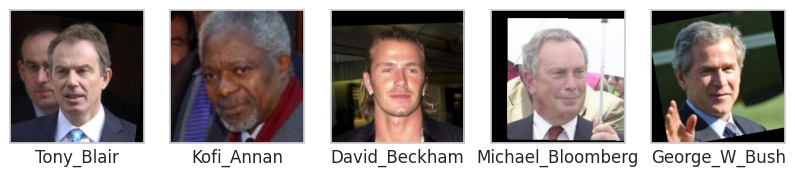

In [31]:
# Function to plot images
def plot_images(images, titles):
    plt.figure(figsize=(10,10))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(titles[i])
    plt.show()

# Plot images from X
plot_images(X, Y)

# Plot images from x_test
plot_images(x_test, y_test)


# **Feature Extraction Using HOG**

### Face Detection

We want to detect and highlight faces in a set of images. We uses OpenCV’s Haar cascades, a machine learning-based approach where a cascade function is trained from a lot of positive and negative images. The detected faces are highlighted with rectangles in the images. These images are then visualized, providing a clear overview of the face detection process. This procedure not only aids in understanding the data but also ensures that the face recognition system is working with accurate inputs and also reduces computational complexity by working with smaller images.

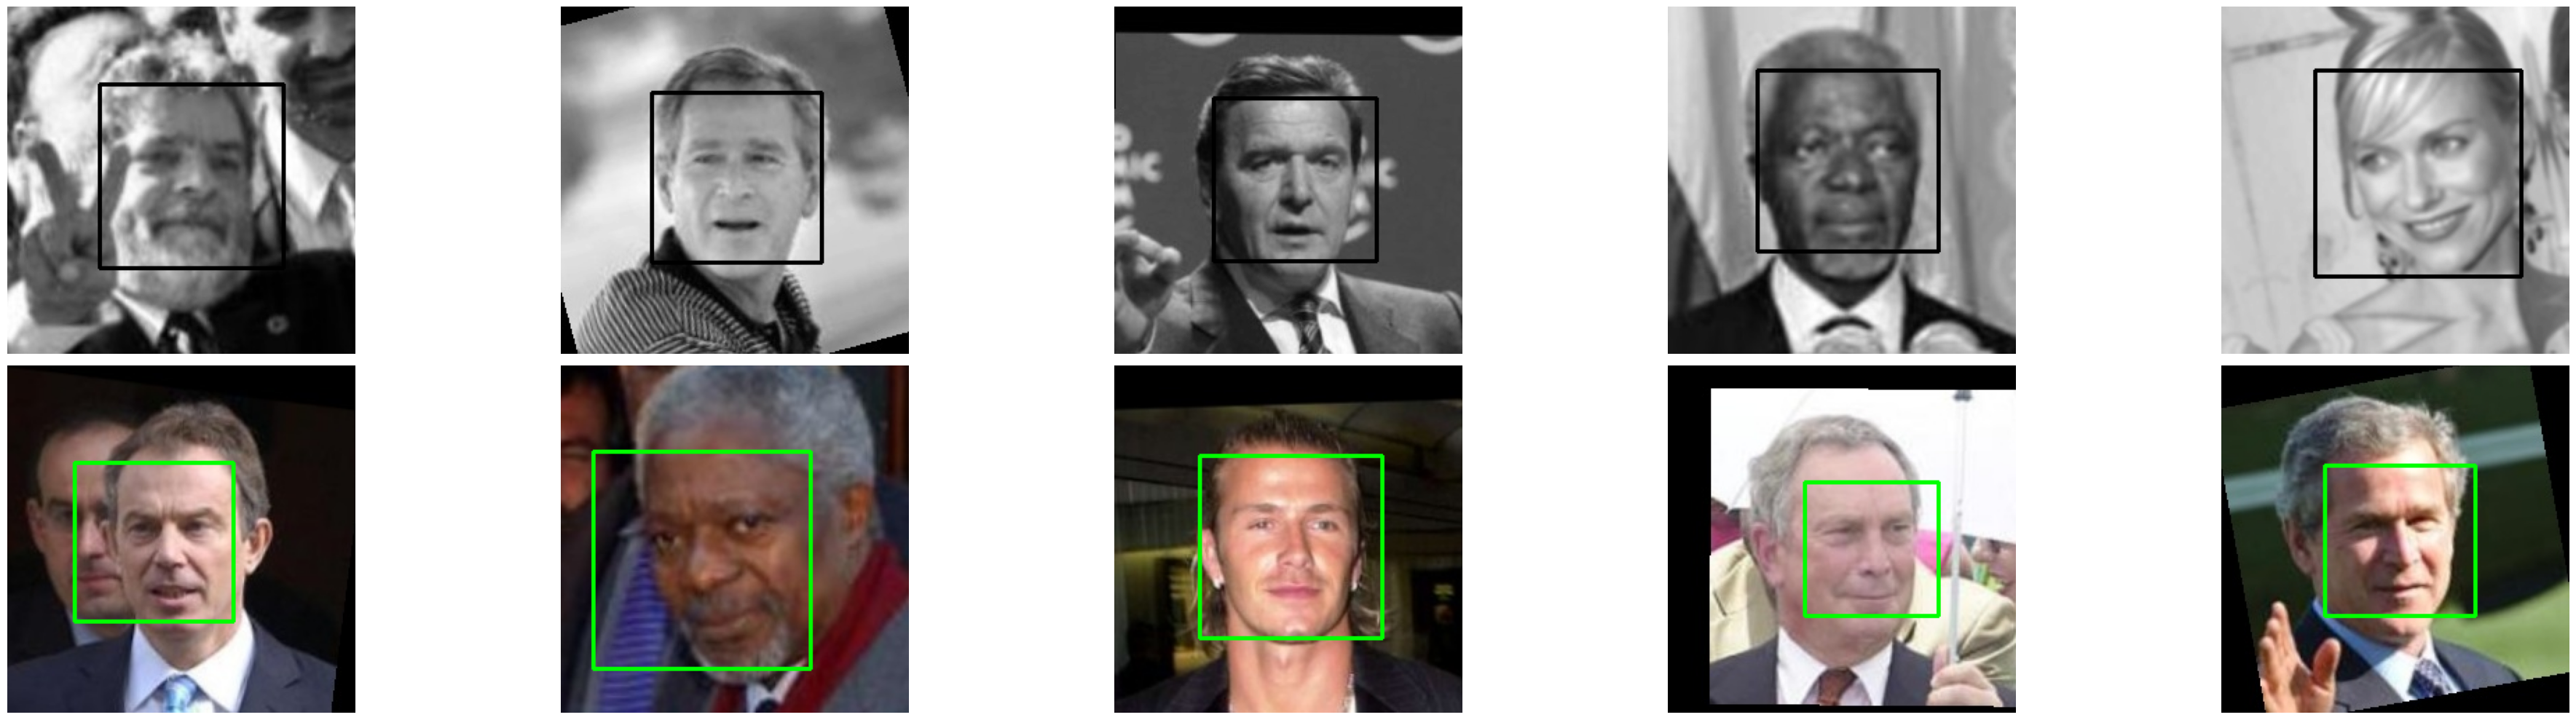

In [32]:
def detect_faces_in_image(input_image):
    # Initialize face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    return image
        

img_faces_train = [
    detect_faces_in_image(image) for i, image in enumerate(X) if i < 5
]
img_faces_test = [
    detect_faces_in_image(image) for i, image in enumerate(x_test) if i < 5
]

fig, axes = plt.subplots(2, 5, figsize=(40, 10))
axes = axes.flatten()
for i in range(10):
    if i < 5:
        ax = axes[i]
        ax.imshow(img_faces_train[i], cmap="gray")
        ax.axis("off")
    else:
        ax = axes[i]
        ax.imshow(img_faces_test[i - 5])
        ax.axis("off")
plt.tight_layout()
plt.show()

### Face Detection and Cropping
Faces are detected in images using Haar cascades, and the detect_and_crop_faces_in_image function is employed for face extraction. Cropping ensures that the subsequent features are focused on the facial regions:

In [33]:
def detect_and_crop_faces_in_image(input_image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If a face is detected, crop it out
    if len(faces) > 0:
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face
    return image

cropped_face_X = []
cropped_face_x_test = []

# Call the function with your images
for image in X:
    cropped_face = detect_and_crop_faces_in_image(image)
    cropped_face_X.append(cropped_face) 

for image in x_test:
    cropped_face = detect_and_crop_faces_in_image(image)
    cropped_face_x_test.append(cropped_face)  


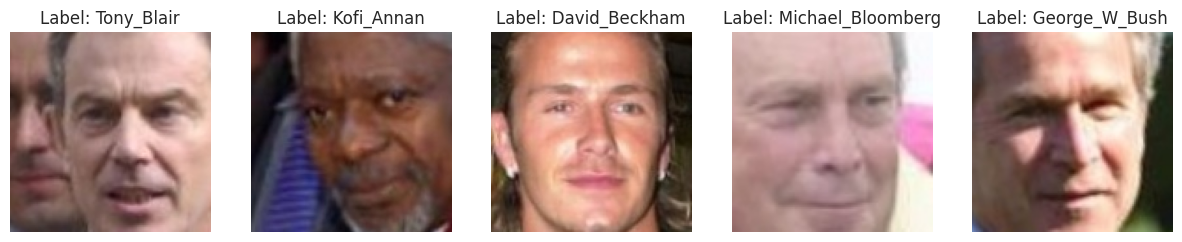

In [34]:
def plot_cropped_image(dataset_images, dataset_labels, num_images=5):
    # Ensure the number of images to plot is not greater than the dataset size
    num_images = min(num_images, len(dataset_images))

    # Create a subplot with a suitable number of rows and columns
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    # Plot each cropped image along with its label
    for i in range(num_images):
        axes[i].imshow(dataset_images[i])  # Assuming dataset_images contains images
        axes[i].set_title(f"Label: {dataset_labels[i]}")
        axes[i].axis('off')

    plt.show()

plot_cropped_image(cropped_face_x_test[:5], y_test[:5])


In [35]:
# final_x_test[0].shape

### Normalize Image

In [36]:
import cv2
import numpy as np

def normalize_images(image_array):
    # Normalize the images 
    for i, image in enumerate(image_array):
        image = ((image - np.min(image)) / (np.max(image) - np.min(image)))
        image_array[i] = image
    return image_array

# Apply the function to our final_X and final_x_test 
final_X = normalize_images(cropped_face_X) 
final_x_test = normalize_images(cropped_face_x_test)


### Feature Extraction - Histogram of Oriented Gradients (HOG)
Feature extraction is a critical step in face recognition systems, transforming high-dimensional image data into a compact and informative format. This process enhances the system’s performance, reliability, and efficiency by reducing computational load, ensuring robustness to image variations, providing discriminatory power for accurate identification, and enabling faster operation.

After reading most related papers, We decided to use the Histogram of Oriented Gradients (HOG) feature descriptor for several reasons:

- Robustness: HOG is robust to local geometric and photometric changes, which means it can handle variations in shape and illumination. This is crucial in face recognition, where lighting conditions and facial expressions can vary greatly.

- Shape Information: HOG captures the shape information in an image by considering the distribution and directions of intensity gradients (edges). This is particularly useful in face recognition, as the shape and structure of facial features are important identifiers.

- Efficiency: HOG is computationally efficient, which is essential for real-time face recognition applications. It allows the system to process images quickly without sacrificing accuracy.

- Versatility: HOG can be used in conjunction with other feature descriptors to improve performance. This flexibility allows me to fine-tune the face recognition system for optimal results.

References: https://iopscience.iop.org/article/10.1088/1742-6596/1664/1/012050
            https://iopscience.iop.org/article/10.1088/1742-6596/1964/6/062023
            https://inria.hal.science/hal-03620410/document
            https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f

In [37]:
def extract_hog_features(images):
    hog_features_list = []
    hog_images_list = []
    for image in images:
        image_resized = transform.resize(image, (128, 64)) # height:128, width=64
        
        # Check if the image is grayscale or color
        if len(image_resized.shape) == 3 and image_resized.shape[2] == 3:
            # The image is a color image, convert it to grayscale
            image_resized_32 = image_resized.astype(np.float32)
            gray = cv2.cvtColor(image_resized_32, cv2.COLOR_BGR2GRAY)
        else:
            # The image is already grayscale
            gray = image_resized
        
        # Extract HOG features
        hog_features, hog_image = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        hog_features_list.append(hog_features)
        hog_images_list.append(hog_image)
    
    return hog_features_list, hog_images_list

hog_features_X, hog_images_X = extract_hog_features(final_X)
hog_features_x_test, hog_images_x_test = extract_hog_features(final_x_test)

In [38]:
print(hog_features_X[0].shape)

(3780,)

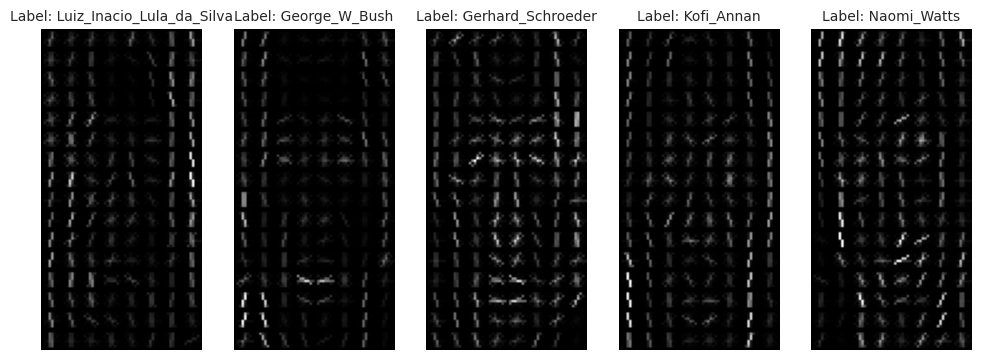

In [39]:
def plot_hog_image(dataset_images, dataset_labels, num_images=5):
    # Ensure the number of images to plot is not greater than the dataset size
    num_images = min(num_images, len(dataset_images))

    # Create a subplot with a suitable number of rows and columns
    fig, axes = plt.subplots(1, num_images, figsize=(12, 5))

    # Plot each cropped image along with its label
    for i in range(num_images):
        axes[i].imshow(dataset_images[i],cmap='gray')  # Assuming dataset_images contains images
        axes[i].set_title(f"Label: {dataset_labels[i]}",size=10)
        axes[i].axis('off')

    plt.show()
    
plot_hog_image(hog_images_X[:5], Y[:5])

In [40]:
pca = PCA(n_components=0.95)  # This will keep 95% of the variance

reduced_features_X = pca.fit_transform(hog_features_X)
reduced_features_x_test = pca.transform(hog_features_x_test)

In [41]:
print("Number of features in training set after PCA: ", reduced_features_X.shape[1])
print("Number of features in test set after PCA: ", reduced_features_x_test.shape[1])

Number of features in training set after PCA:  870

Number of features in test set after PCA:  870

# Data Training using SVM(Support Vector Machine), Knn(K-nearest Neighbor), DT(Decision Tree)

In [42]:
# Param
dt_param_grid = {'max_depth': [None, 5, 10, 15]}
knn_params = {'n_neighbors': [5, 10, 15],'weights': ['uniform', 'distance']}
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'],'probability':[True]}

dt_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=3)

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, verbose=1, cv=3)

svm_classifier = SVC()
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=3)

# Training

dt_grid_search.fit(reduced_features_X, Y)
knn_grid.fit(reduced_features_X, Y)
svm_grid_search.fit(reduced_features_X, Y)

# Predict
dt_y_pred = dt_grid_search.predict(reduced_features_x_test)
knn_preds = knn_grid.predict(reduced_features_x_test)
svm_y_pred = svm_grid_search.predict(reduced_features_x_test)


# Print classification report and accuracy for Decision Tree
dt_classification_report = classification_report(y_test, dt_y_pred)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
# Print best parameters and scores for Decision Tree
print("Best parameters for Decision Tree:", dt_grid_search.best_params_)
print("Best cross-validated score for Decision Tree:", dt_grid_search.best_score_)
print(f"Accuracy for Decision Tree: {dt_accuracy:.2f}")
print("\nDecision Tree Metrics:")
print(dt_classification_report)


print("==========================")

knn_acc = accuracy_score(y_test, knn_preds)
knn_report = classification_report(y_test, knn_preds)
# Print best parameters and scores for Decision Tree
print('KNN best params:', knn_grid.best_params_)
print("Best cross-validated score for KNN:", knn_grid.best_score_)
print('KNN accuracy:', knn_acc)
print("\Knn Metrics:")
print(knn_report)

print("==========================")

# Print classification report and accuracy for SVM
svm_classification_report = classification_report(y_test, svm_y_pred)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best cross-validated score for SVM:", svm_grid_search.best_score_)
print(f"Accuracy for SVM: {svm_accuracy:.2f}")
print("SVM Metrics:")
print(svm_classification_report)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


Best parameters for Decision Tree:
{'max_depth': None}

Best cross-validated score for Decision Tree: 0.2983420275693495

Accuracy for Decision Tree: 0.17

Decision Tree Metrics:

precision    recall  f1-score   support

         Alejandro_Toledo       0.09      0.08      0.09        12
             Alvaro_Uribe       0.00      0.00      0.00        10
          Amelie_Mauresmo       0.17      0.17      0.17         6
             Andre_Agassi       0.00      0.00      0.00        11
           Angelina_Jolie       0.22      0.33      0.27         6
             Ariel_Sharon       0.26      0.22      0.24        23
    Arnold_Schwarzenegger       0.00      0.00      0.00        13
     Atal_Bihari_Vajpayee       0.07      0.14      0.09         7
             Bill_Clinton       0.05      0.11      0.07         9
             Carlos_Menem       0.00      0.00      0.00         6
             Colin_Powell       0.55      0.25      0.35        71
            David_Beckham       0.00      0.00      0.00         9
          Donald_Rumsfeld       0.22      0.17      0.19        36
         George_Robertson       0.12      0.14      0.13         7
            George_W_Bush       0.74      0.36      0.48       159
        Gerhard_Schroeder       0.09      0.06      0.07        33
  Gloria_Macapagal_Arroyo       0.30      0.23      0.26        13
               Gray_Davis       0.00      0.00      0.00         8
          Guillermo_Coria       0.00      0.00      0.00         9
             Hamid_Karzai       0.00      0.00      0.00         7
                Hans_Blix       0.00      0.00      0.00        12
              Hugo_Chavez       0.33      0.29      0.31        21
              Igor_Ivanov       0.00      0.00      0.00         6
               Jack_Straw       0.17      0.25      0.20         8
           Jacques_Chirac       0.13      0.19      0.15        16
            Jean_Chretien       0.10      0.06      0.08        16
         Jennifer_Aniston       0.33      0.33      0.33         6
        Jennifer_Capriati       0.00      0.00      0.00        13
           Jennifer_Lopez       0.00      0.00      0.00         6
        Jeremy_Greenstock       0.00      0.00      0.00         7
              Jiang_Zemin       0.38      0.50      0.43         6
            John_Ashcroft       0.07      0.06      0.06        16
          John_Negroponte       0.00      0.00      0.00         9
         Jose_Maria_Aznar       0.00      0.00      0.00         7
      Juan_Carlos_Ferrero       0.00      0.00      0.00         8
        Junichiro_Koizumi       0.17      0.17      0.17        18
               Kofi_Annan       0.17      0.20      0.18        10
               Laura_Bush       0.10      0.08      0.09        12
        Lindsay_Davenport       0.00      0.00      0.00         7
           Lleyton_Hewitt       0.12      0.17      0.14        12
Luiz_Inacio_Lula_da_Silva       0.17      0.21      0.19        14
            Mahmoud_Abbas       0.07      0.11      0.09         9
    Megawati_Sukarnoputri       0.46      0.60      0.52        10
        Michael_Bloomberg       0.00      0.00      0.00         6
              Naomi_Watts       0.08      0.17      0.11         6
          Nestor_Kirchner       0.00      0.00      0.00        11
              Paul_Bremer       0.00      0.00      0.00         6
             Pete_Sampras       0.00      0.00      0.00         7
     Recep_Tayyip_Erdogan       0.00      0.00      0.00         9
            Ricardo_Lagos       0.00      0.00      0.00         8
             Roh_Moo-hyun       0.44      0.40      0.42        10
         Rudolph_Giuliani       0.00      0.00      0.00         8
           Saddam_Hussein       0.10      0.14      0.12         7
          Serena_Williams       0.00      0.00      0.00        16
        Silvio_Berlusconi       0.00      0.00      0.00        10
              Tiger_Woods       0.18      0.29      0.22         7
              Tom_Daschle       0.00      0.00      0.00         7
                Tom_Ridge       0.10      0.20      0.13        10
               Tony_Blair       0.24      0.12      0.16        43
      

==========================

KNN best params:
{'n_neighbors': 5, 'weights': 'distance'}

Best cross-validated score for KNN: 0.8261324035374003

KNN accuracy: 0.6560088202866593

\Knn Metrics:

precision    recall  f1-score   support

         Alejandro_Toledo       0.64      0.58      0.61        12
             Alvaro_Uribe       1.00      0.30      0.46        10
          Amelie_Mauresmo       0.67      0.33      0.44         6
             Andre_Agassi       0.56      0.45      0.50        11
           Angelina_Jolie       0.50      0.50      0.50         6
             Ariel_Sharon       0.71      0.87      0.78        23
    Arnold_Schwarzenegger       0.50      0.23      0.32        13
     Atal_Bihari_Vajpayee       0.75      0.86      0.80         7
             Bill_Clinton       0.50      0.22      0.31         9
             Carlos_Menem       0.19      0.67      0.30         6
             Colin_Powell       0.88      0.82      0.85        71
            David_Beckham       0.25      0.22      0.24         9
          Donald_Rumsfeld       0.59      0.75      0.66        36
         George_Robertson       0.25      0.29      0.27         7
            George_W_Bush       0.73      0.79      0.76       159
        Gerhard_Schroeder       0.76      0.76      0.76        33
  Gloria_Macapagal_Arroyo       0.89      0.62      0.73        13
               Gray_Davis       0.60      0.38      0.46         8
          Guillermo_Coria       0.86      0.67      0.75         9
             Hamid_Karzai       0.50      0.71      0.59         7
                Hans_Blix       0.77      0.83      0.80        12
              Hugo_Chavez       0.85      0.52      0.65        21
              Igor_Ivanov       0.25      0.50      0.33         6
               Jack_Straw       0.75      0.38      0.50         8
           Jacques_Chirac       0.33      0.50      0.40        16
            Jean_Chretien       0.67      0.75      0.71        16
         Jennifer_Aniston       0.62      0.83      0.71         6
        Jennifer_Capriati       0.75      0.46      0.57        13
           Jennifer_Lopez       0.40      0.33      0.36         6
        Jeremy_Greenstock       0.83      0.71      0.77         7
              Jiang_Zemin       0.83      0.83      0.83         6
            John_Ashcroft       0.45      0.56      0.50        16
          John_Negroponte       0.62      0.89      0.73         9
         Jose_Maria_Aznar       1.00      0.29      0.44         7
      Juan_Carlos_Ferrero       0.45      0.62      0.53         8
        Junichiro_Koizumi       1.00      0.89      0.94        18
               Kofi_Annan       0.82      0.90      0.86        10
               Laura_Bush       1.00      0.58      0.74        12
        Lindsay_Davenport       0.60      0.43      0.50         7
           Lleyton_Hewitt       0.83      0.83      0.83        12
Luiz_Inacio_Lula_da_Silva       0.65      0.93      0.76        14
            Mahmoud_Abbas       0.75      0.67      0.71         9
    Megawati_Sukarnoputri       1.00      0.90      0.95        10
        Michael_Bloomberg       0.00      0.00      0.00         6
              Naomi_Watts       0.43      0.50      0.46         6
          Nestor_Kirchner       0.40      0.55      0.46        11
              Paul_Bremer       0.50      0.50      0.50         6
             Pete_Sampras       1.00      0.57      0.73         7
     Recep_Tayyip_Erdogan       0.54      0.78      0.64         9
            Ricardo_Lagos       0.50      0.62      0.56         8
             Roh_Moo-hyun       1.00      0.80      0.89        10
         Rudolph_Giuliani       0.09      0.12      0.11         8
           Saddam_Hussein       0.60      0.86      0.71         7
          Serena_Williams       0.86      0.75      0.80        16
        Silvio_Berlusconi       0.38      0.30      0.33        10
              Tiger_Woods       0.50      0.43      0.46         7
              Tom_Daschle       0.44      0.57      0.50         7
                Tom_Ridge       0.70      0.70      0.70        10
               Tony_Blair       0.85      0.65      0.74        43
      

==========================

Best parameters for SVM:
{'C': 10, 'kernel': 'rbf', 'probability': True}

Best cross-validated score for SVM: 0.8893661023975187

Accuracy for SVM: 0.79

SVM Metrics:

precision    recall  f1-score   support

         Alejandro_Toledo       1.00      0.92      0.96        12
             Alvaro_Uribe       1.00      0.70      0.82        10
          Amelie_Mauresmo       0.50      0.50      0.50         6
             Andre_Agassi       0.56      0.91      0.69        11
           Angelina_Jolie       0.67      0.33      0.44         6
             Ariel_Sharon       1.00      0.96      0.98        23
    Arnold_Schwarzenegger       0.50      0.54      0.52        13
     Atal_Bihari_Vajpayee       0.67      0.86      0.75         7
             Bill_Clinton       0.70      0.78      0.74         9
             Carlos_Menem       0.50      0.50      0.50         6
             Colin_Powell       0.93      0.90      0.91        71
            David_Beckham       0.40      0.22      0.29         9
          Donald_Rumsfeld       0.75      0.83      0.79        36
         George_Robertson       0.75      0.43      0.55         7
            George_W_Bush       0.79      0.91      0.85       159
        Gerhard_Schroeder       0.84      0.94      0.89        33
  Gloria_Macapagal_Arroyo       0.79      0.85      0.81        13
               Gray_Davis       0.67      0.50      0.57         8
          Guillermo_Coria       0.57      0.89      0.70         9
             Hamid_Karzai       0.46      0.86      0.60         7
                Hans_Blix       0.83      0.83      0.83        12
              Hugo_Chavez       0.94      0.76      0.84        21
              Igor_Ivanov       0.80      0.67      0.73         6
               Jack_Straw       1.00      0.75      0.86         8
           Jacques_Chirac       0.71      0.75      0.73        16
            Jean_Chretien       0.88      0.88      0.88        16
         Jennifer_Aniston       0.83      0.83      0.83         6
        Jennifer_Capriati       0.73      0.62      0.67        13
           Jennifer_Lopez       1.00      0.50      0.67         6
        Jeremy_Greenstock       1.00      0.57      0.73         7
              Jiang_Zemin       1.00      0.83      0.91         6
            John_Ashcroft       0.93      0.81      0.87        16
          John_Negroponte       0.80      0.89      0.84         9
         Jose_Maria_Aznar       1.00      0.57      0.73         7
      Juan_Carlos_Ferrero       0.88      0.88      0.88         8
        Junichiro_Koizumi       0.85      0.94      0.89        18
               Kofi_Annan       1.00      0.60      0.75        10
               Laura_Bush       0.79      0.92      0.85        12
        Lindsay_Davenport       1.00      0.57      0.73         7
           Lleyton_Hewitt       0.92      0.92      0.92        12
Luiz_Inacio_Lula_da_Silva       0.88      1.00      0.93        14
            Mahmoud_Abbas       0.70      0.78      0.74         9
    Megawati_Sukarnoputri       1.00      0.90      0.95        10
        Michael_Bloomberg       0.50      0.17      0.25         6
              Naomi_Watts       0.45      0.83      0.59         6
          Nestor_Kirchner       0.67      0.91      0.77        11
              Paul_Bremer       1.00      0.50      0.67         6
             Pete_Sampras       1.00      0.86      0.92         7
     Recep_Tayyip_Erdogan       1.00      0.89      0.94         9
            Ricardo_Lagos       0.75      0.75      0.75         8
             Roh_Moo-hyun       1.00      0.70      0.82        10
         Rudolph_Giuliani       1.00      0.62      0.77         8
           Saddam_Hussein       0.60      0.86      0.71         7
          Serena_Williams       0.68      0.81      0.74        16
        Silvio_Berlusconi       0.67      0.40      0.50        10
              Tiger_Woods       0.60      0.43      0.50         7
              Tom_Daschle       1.00      0.71      0.83         7
                Tom_Ridge       0.82      0.90      0.86        10
               Tony_Blair       0.85      0.79      0.82        43
      

### SVM Classifier Training and Evaluation
A Support Vector Machine (SVM) classifier is trained on the extracted HOG features, and its performance is evaluated on a validation set. SVMs are chosen for their effectiveness in high-dimensional feature spaces. SVMs work well for classification tasks, especially when the feature space is not linearly separable. The kernel trick allows SVMs to capture complex relationships in the data:

In [43]:
best_model = svm_grid_search.best_estimator_

In [44]:
# Find accuracy on training set
y_predict_on_train = best_model.predict(reduced_features_X)
svm_accuracy_on_train = accuracy_score(Y, y_predict_on_train)
print(f"Accuracy on training set for SVM: {svm_accuracy_on_train:.2f}")

Accuracy on training set for SVM: 1.00

In [45]:
# Obtain probability estimates
probability_estimates = best_model.predict_proba([reduced_features_X[0]])
# sorted_floats_descending = sorted(probability_estimates[0], reverse=True)
print("Probability estimates:")
print(probability_estimates)

Probability estimates:

[[3.25304629e-04 7.34367100e-04 6.51109543e-04 5.72744880e-04
  1.11702717e-04 3.75207108e-04 7.03467237e-04 1.74390946e-03
  1.36408992e-04 1.09958231e-03 1.82833713e-04 5.89567038e-04
  1.20737383e-03 8.37594595e-04 2.30390361e-03 8.14724564e-04
  7.43942151e-05 1.02019834e-03 4.65310013e-05 2.19535321e-03
  3.88144584e-04 9.99393314e-04 3.98703818e-04 1.37402821e-04
  4.34064183e-04 1.79721403e-03 1.75313163e-04 5.38278145e-04
  1.05053764e-04 1.99748300e-04 2.40263723e-04 6.18156737e-04
  2.61775640e-04 1.21002603e-04 2.04525673e-04 7.14158089e-04
  7.91146356e-04 9.88740186e-05 4.22847884e-04 2.44611044e-04
  9.65228890e-01 9.43988148e-04 2.74856713e-04 7.82722896e-04
  4.83442738e-04 3.15585524e-04 1.45864729e-04 1.07883480e-03
  2.45739797e-04 7.21253534e-04 1.34924748e-04 7.70376560e-04
  2.29651887e-03 1.74770046e-04 3.65884298e-04 5.32526465e-05
  1.25873050e-04 5.63026863e-05 3.16367841e-04 6.35787552e-04
  1.10227767e-04 1.21578802e-04]]

In [46]:
class_labels = best_model.classes_
class_labels

array(['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo',
       'Andre_Agassi', 'Angelina_Jolie', 'Ariel_Sharon',
       'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton',
       'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld',
       'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder',
       'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria',
       'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov',
       'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien',
       'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez',
       'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft',
       'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero',
       'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush',
       'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva',
       'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Michael_Bloomberg',
       'Naomi_Watts', 'Nestor_Kirchner', 'Paul_Bremer', 'Pete_Sampras',
       'Rece

In [47]:
# Sample prediction 
prob_label_pairs = list(zip(probability_estimates[0], class_labels))

# Sort based on probabilities (in descending order)
sorted_pairs = sorted(prob_label_pairs, key=lambda x: x[0], reverse=True)

# Print the sorted results
for prob, label in sorted_pairs:
    print(f"{label}: {prob * 100:.3f}%")

Luiz_Inacio_Lula_da_Silva: 96.523%

George_W_Bush: 0.230%

Saddam_Hussein: 0.230%

Hamid_Karzai: 0.220%

Jean_Chretien: 0.180%

Atal_Bihari_Vajpayee: 0.174%

Donald_Rumsfeld: 0.121%

Carlos_Menem: 0.110%

Pete_Sampras: 0.108%

Gray_Davis: 0.102%

Hugo_Chavez: 0.100%

Mahmoud_Abbas: 0.094%

George_Robertson: 0.084%

Gerhard_Schroeder: 0.081%

Kofi_Annan: 0.079%

Michael_Bloomberg: 0.078%

Rudolph_Giuliani: 0.077%

Alvaro_Uribe: 0.073%

Ricardo_Lagos: 0.072%

Junichiro_Koizumi: 0.071%

Arnold_Schwarzenegger: 0.070%

Amelie_Mauresmo: 0.065%

Vicente_Fox: 0.064%

John_Ashcroft: 0.062%

David_Beckham: 0.059%

Andre_Agassi: 0.057%

Jennifer_Capriati: 0.054%

Naomi_Watts: 0.048%

Jacques_Chirac: 0.043%

Lindsay_Davenport: 0.042%

Igor_Ivanov: 0.040%

Hans_Blix: 0.039%

Ariel_Sharon: 0.038%

Silvio_Berlusconi: 0.037%

Alejandro_Toledo: 0.033%

Tony_Blair: 0.032%

Nestor_Kirchner: 0.032%

Megawati_Sukarnoputri: 0.027%

John_Negroponte: 0.026%

Recep_Tayyip_Erdogan: 0.025%

Lleyton_Hewitt: 0.024%

Jiang_Zemin: 0.024%

Juan_Carlos_Ferrero: 0.020%

Jeremy_Greenstock: 0.020%

Colin_Powell: 0.018%

Jennifer_Aniston: 0.018%

Serena_Williams: 0.017%

Paul_Bremer: 0.015%

Jack_Straw: 0.014%

Bill_Clinton: 0.014%

Roh_Moo-hyun: 0.013%

Tom_Daschle: 0.013%

Winona_Ryder: 0.012%

Jose_Maria_Aznar: 0.012%

Angelina_Jolie: 0.011%

Vladimir_Putin: 0.011%

Jennifer_Lopez: 0.011%

Laura_Bush: 0.010%

Gloria_Macapagal_Arroyo: 0.007%

Tom_Ridge: 0.006%

Tiger_Woods: 0.005%

Guillermo_Coria: 0.005%

### Confusion Matrix

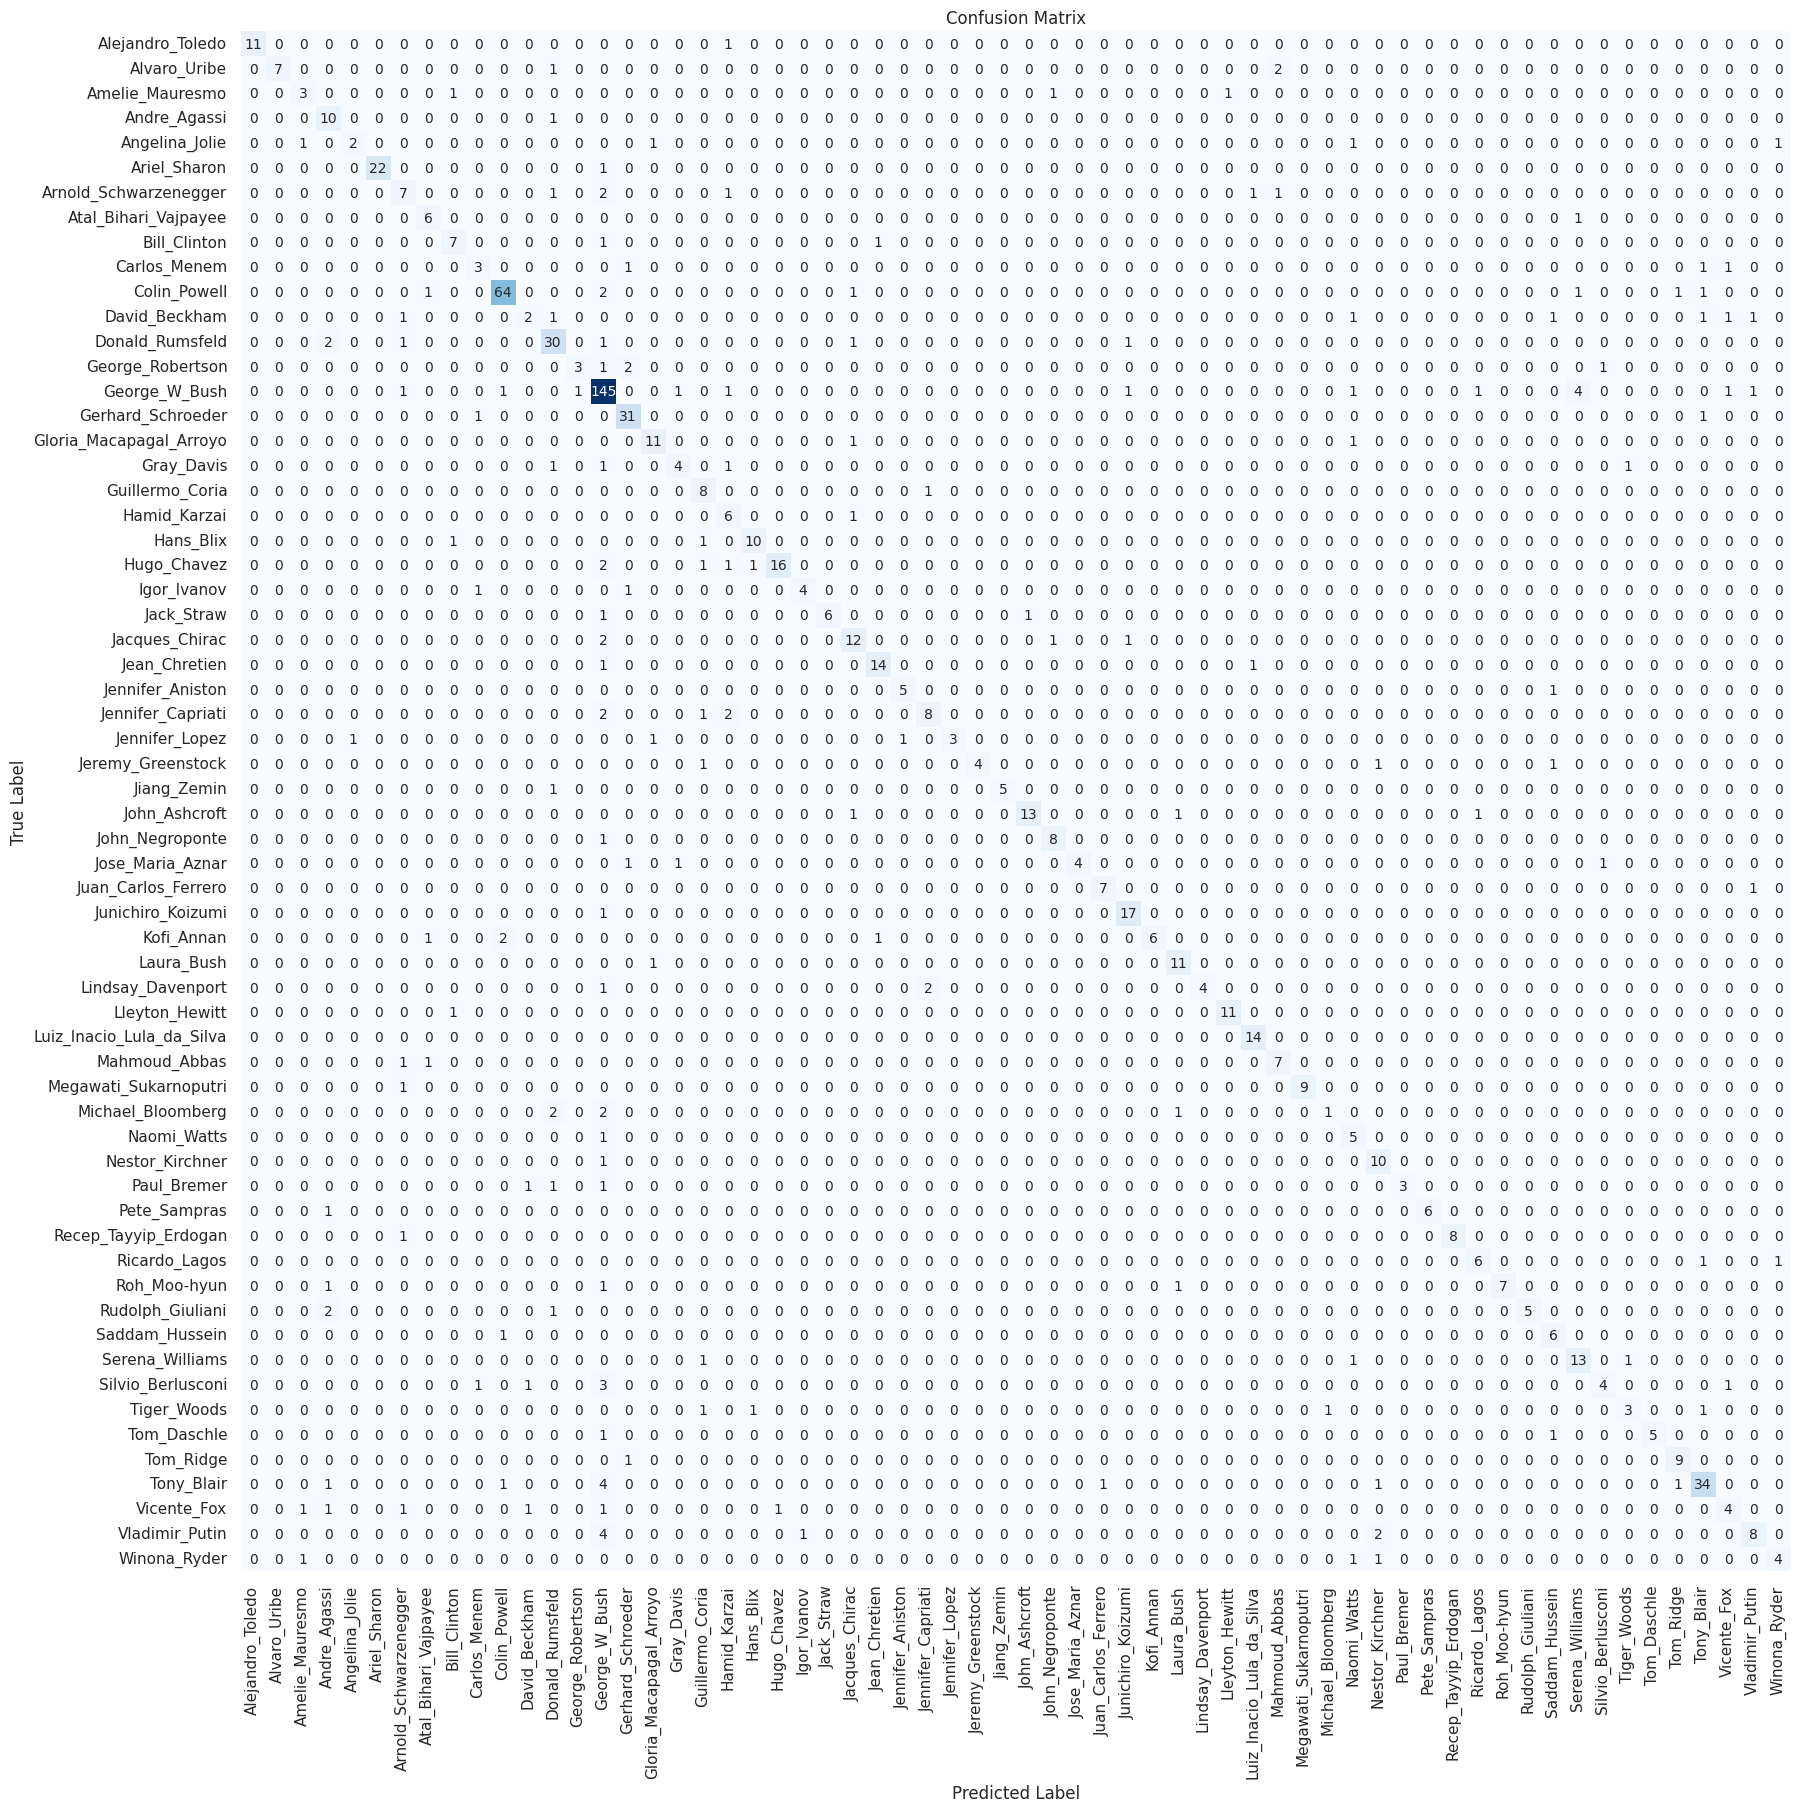

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, svm_y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xticks(rotation=90)  # Rotates x-axis labels
plt.yticks(rotation=0) 
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Bar chart of the F1 score for each class

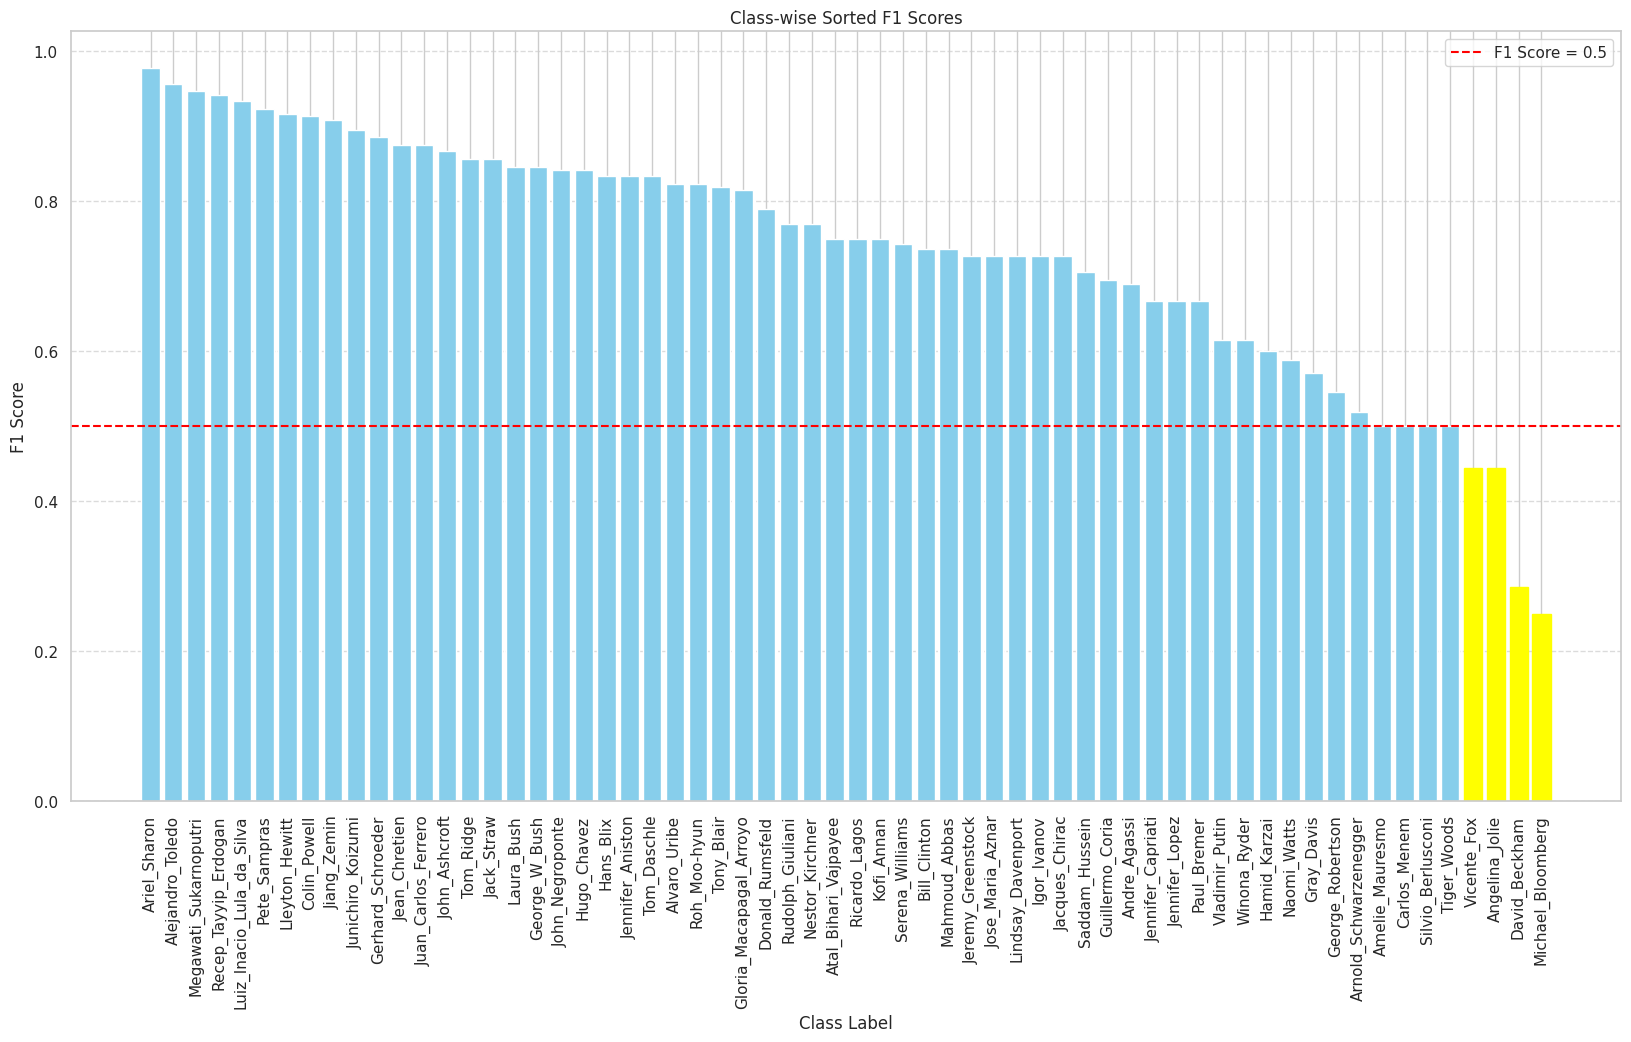

In [49]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_test, svm_y_pred, average=None)

class_f1_pairs = list(zip(class_labels, f1_scores))

class_f1_pairs.sort(key=lambda x: x[1], reverse=True)

sorted_labels, sorted_f1_scores = zip(*class_f1_pairs)

plt.figure(figsize=(20, 10))
bars = plt.bar(sorted_labels, sorted_f1_scores, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('F1 Score')
plt.title('Class-wise Sorted F1 Scores')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a red dashed line at F1 score 0.6
plt.axhline(y=0.5, color='red', linestyle='--', label='F1 Score = 0.5')

# Highlight bars below F1 score 0.6 in yellow
for bar, f1_score in zip(bars, sorted_f1_scores):
    if f1_score < 0.5:
        bar.set_color('yellow')

# Add legend
plt.legend()

plt.show()

In [50]:
# Specify the directory path
directory_path = '/kaggle/working/model_export/'
# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

with open(os.path.join(directory_path, 'svm_model_hog_64_128_aug_upto_160.pkl'), 'wb') as model_file:
    pickle.dump(best_model, model_file)